In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('C:/Users/user/OneDrive/Desktop/Kaggle/airline-passengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index(['Month'], inplace=True)
dataset

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

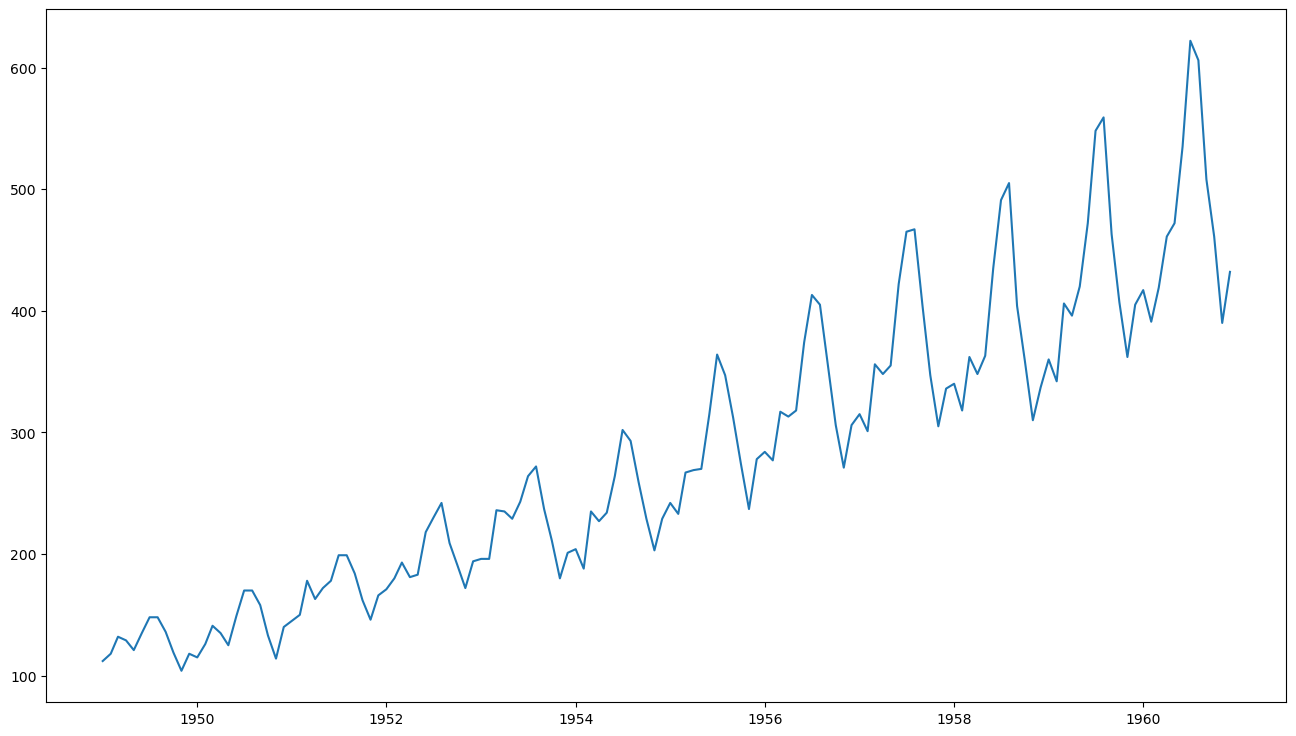

In [3]:
    plt.figure(figsize=(16,9))
    plt.plot(dataset['Passengers'])
    plt.show()

In [4]:
#Dataset creation

scaler = MinMaxScaler(feature_range=(0, 1))

def create_dataset(df, train_size, lback, scaler_function=scaler):
    test_size = len(df) - train_size - val_size
    train, val, test = df[0:train_size,:].copy(), df[train_size-lback-1:(val_size+train_size)-lback-1,:].copy(), df[(val_size+train_size)-(2*lback)-2:len(df),:].copy()
    train = scaler_function.fit_transform(train)
    val = scaler_function.transform(val)
    test = scaler_function.transform(test)
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []

    # Train dataset creation
    for i in range(len(train)-lback-1):
        a = train[i:(i+lback), 0]
        X_train.append(a)
        y_train.append(train[i + lback, 0])

    # Validation dataset creation
    for i in range(len(val)-lback-1):
        a = val[i:(i+lback), 0]
        X_val.append(a)
        y_val.append(val[i + lback, 0])

    # Test dataset creation
    for i in range(len(test)-lback-1):
        a = test[i:(i+lback), 0]
        X_test.append(a)
        y_test.append(test[i + lback, 0])

    X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
    X_train, X_val, X_test = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])), np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])), np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
def rmse_test(model):
    # prediction - training dataset
    prediction_train = scaler.inverse_transform(model.predict(X_train))
    prediction_train = pd.Series(prediction_train.flatten(),
                                index=dataset.index[:len(prediction_train)])
    # prediction - validation dataset
    prediction_val = scaler.inverse_transform(model.predict(X_val))
    prediction_val = pd.Series(prediction_val.flatten(),
                                index=dataset.index[len(prediction_train):len(prediction_train)+len(prediction_val)])

    # prediction - test dataset
    prediction_test = scaler.inverse_transform(model.predict(X_test))
    prediction_test = pd.Series(prediction_test.flatten(),
                                index=dataset.index[len(prediction_train)+len(prediction_val):len(prediction_train)+len(prediction_val)+len(prediction_test)])
    # RMSE
    rmse = mean_squared_error(dataset.loc[prediction_test.index, :], prediction_test) ** 0.5
    return rmse

In [6]:
#Best parameters search basing on RMSE for test dataset

result_list=[]
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.15)
scaler = MinMaxScaler(feature_range=(0, 1))

for lback in range (1,13):
  for units in range (1,13):
    X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=lback, scaler_function=scaler)
    model_gru = Sequential()
    model_gru.add(GRU(units, input_shape=(1, lback)))
    model_gru.add(Dense(1))
    model_gru.compile(loss='mean_squared_error', optimizer='adam')
    model_gru.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, validation_data=(X_val, y_val))
    result=rmse_test(model_gru)
    result_list.append((result, lback, units))

df_results = pd.DataFrame(result_list, columns=['result', 'lback', 'units'])
df_results=df_results.sort_values(by='result', ascending=True)
df_results

Epoch 1/200
98/98 [==============================] - 2s 6ms/step - loss: 0.0390 - val_loss: 0.2040
Epoch 2/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.1511
Epoch 3/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.1268
Epoch 4/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.1103
Epoch 5/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0965
Epoch 6/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0845
Epoch 7/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0766
Epoch 8/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0670
Epoch 9/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0557
Epoch 10/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0547
Epoch 11/

result  lback  units
138   24.209963     12      7
132   30.900028     12      1
5     30.976009      1      6
9     31.004125      1     10
143   31.733758     12     12
..          ...    ...    ...
40   118.502777      4      5
33   119.003074      3     10
45   122.659599      4     10
32   122.887541      3      9
26   127.592910      3      3

[144 rows x 3 columns]

In [7]:
# Training neural network
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.15)
scaler = MinMaxScaler(feature_range=(0, 1)) 
lback=12
units=7

X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=lback, scaler_function=scaler)
model_gru = Sequential()
model_gru.add(GRU(units, input_shape=(1, lback)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')
model_gru.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, validation_data=(X_val, y_val))

Epoch 1/200
87/87 [==============================] - 2s 5ms/step - loss: 0.0098 - val_loss: 0.0471
Epoch 2/200
87/87 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0421
Epoch 3/200
87/87 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0225
Epoch 4/200
87/87 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0198
Epoch 5/200
87/87 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0214
Epoch 6/200
87/87 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0159
Epoch 7/200
87/87 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0157
Epoch 8/200
87/87 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0140
Epoch 9/200
87/87 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0118
Epoch 10/200
87/87 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0115
Epoch 11/

In [8]:
def visualisation(model,lback):

    # prediction - training dataset
    prediction_train = scaler.inverse_transform(model.predict(X_train))
    prediction_train = pd.Series(prediction_train.flatten(),
                                index=dataset.index[lback:len(prediction_train)+lback])
    # prediction - validation dataset
    prediction_val = scaler.inverse_transform(model.predict(X_val))
    prediction_val = pd.Series(prediction_val.flatten(),
                                index=dataset.index[len(prediction_train)+lback:len(prediction_train)+len(prediction_val)+lback])

    # prediction - test dataset
    prediction_test = scaler.inverse_transform(model.predict(X_test))
    prediction_test = pd.Series(prediction_test.flatten(),
                                index=dataset.index[len(prediction_train)+len(prediction_val)+lback:len(prediction_train)+len(prediction_val)+len(prediction_test)+lback])

    # chart
    plt.figure(figsize=(16,9))
    plt.plot(dataset['Passengers'], color='blue', label='True values')
    plt.plot(prediction_train, color='green', label='Prediction - Train')
    plt.plot(prediction_val, color='orange', label='Prediction - Val')
    plt.plot(prediction_test, color='red', label='Prediction - Test')
    plt.legend(loc='upper left')
    plt.show()

2/2 [==============================] - 0s 0s/step


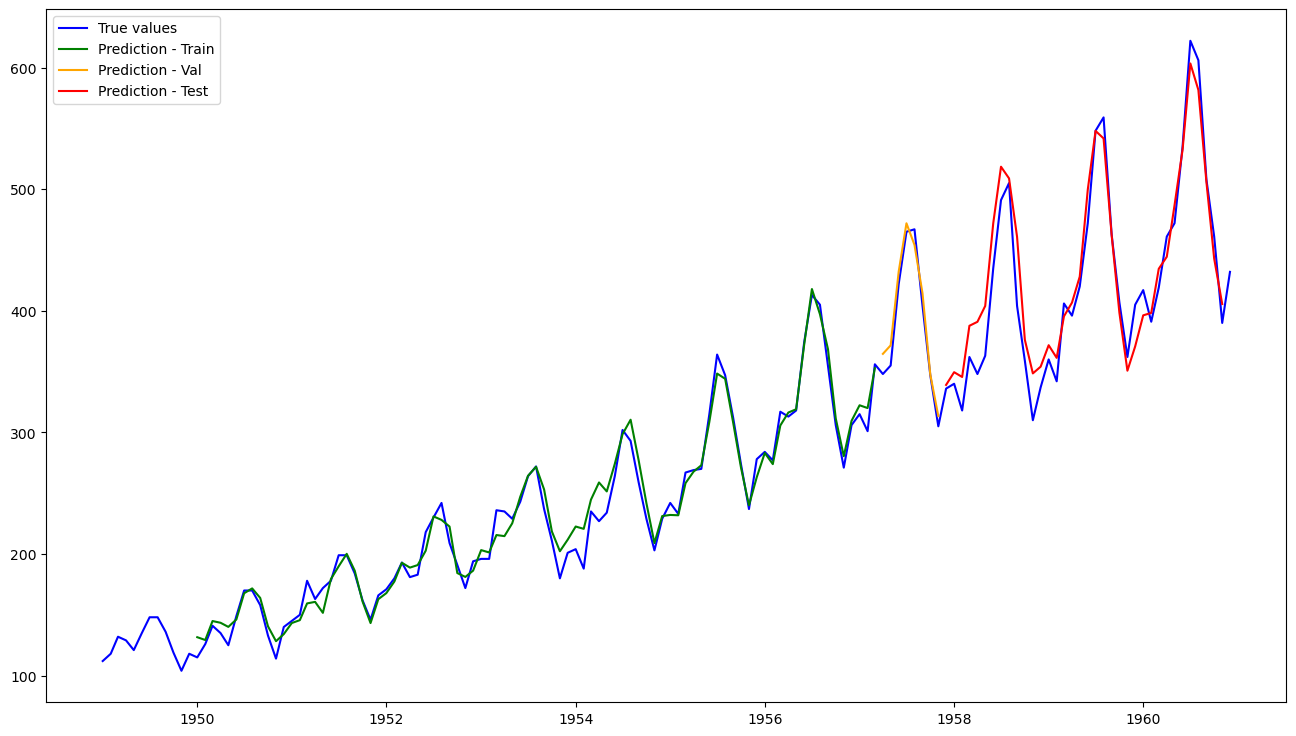

In [9]:
visualisation(model_gru,lback=lback)

In [10]:
def rmse_val(model):
    # prediction - training dataset
    prediction_train = scaler.inverse_transform(model.predict(X_train))
    prediction_train = pd.Series(prediction_train.flatten(),
                                index=dataset.index[:len(prediction_train)])
    # prediction - validation dataset
    prediction_val = scaler.inverse_transform(model.predict(X_val))
    prediction_val = pd.Series(prediction_val.flatten(),
                                index=dataset.index[len(prediction_train):len(prediction_train)+len(prediction_val)])

    # prediction - test dataset
    prediction_test = scaler.inverse_transform(model.predict(X_test))
    prediction_test = pd.Series(prediction_test.flatten(),
                                index=dataset.index[len(prediction_train)+len(prediction_val):len(prediction_train)+len(prediction_val)+len(prediction_test)])
    # RMSE
    rmse = mean_squared_error(dataset.loc[prediction_val.index, :], prediction_val) ** 0.5
    return rmse

In [11]:
#Best parameters search basing on RMSE for validation dataset

result_list=[]
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.15)
scaler = MinMaxScaler(feature_range=(0, 1))

for lback in range (1,13):
  for units in range (1,13):
    X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=lback, scaler_function=scaler)
    model_gru_2 = Sequential()
    model_gru_2.add(GRU(units, input_shape=(1, lback)))
    model_gru_2.add(Dense(1))
    model_gru_2.compile(loss='mean_squared_error', optimizer='adam')
    model_gru_2.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, validation_data=(X_val, y_val))
    result=rmse_val(model_gru_2)
    result_list.append((result, lback, units))

df_results = pd.DataFrame(result_list, columns=['result', 'lback', 'units'])
df_results=df_results.sort_values(by='result', ascending=True)
df_results

Epoch 1/200
98/98 [==============================] - 2s 5ms/step - loss: 0.1273 - val_loss: 0.4764
Epoch 2/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.2839
Epoch 3/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.2039
Epoch 4/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.1661
Epoch 5/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.1552
Epoch 6/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.1362
Epoch 7/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.1294
Epoch 8/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.1145
Epoch 9/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.1068
Epoch 10/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0196 - val_loss: 0.0905
Epoch 11/

result  lback  units
9   12.670962      1     10
0   14.303451      1      1
11  14.648007      1     12
4   17.413417      1      5
10  19.902824      1     11
..        ...    ...    ...
76  85.168415      7      5
82  85.337750      7     11
78  86.014536      7      7
80  86.810975      7      9
75  87.806154      7      4

[144 rows x 3 columns]

In [12]:
# Training neural network
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.15)
scaler = MinMaxScaler(feature_range=(0, 1))
lback=1
units=10

X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=lback, scaler_function=scaler)
model_gru_2 = Sequential()
model_gru_2.add(GRU(units, input_shape=(1, lback)))
model_gru_2.add(Dense(1))
model_gru_2.compile(loss='mean_squared_error', optimizer='adam')
model_gru_2.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, validation_data=(X_val, y_val))

Epoch 1/200
98/98 [==============================] - 2s 5ms/step - loss: 0.0883 - val_loss: 0.2847
Epoch 2/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.1600
Epoch 3/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.1380
Epoch 4/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.1065
Epoch 5/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0186 - val_loss: 0.0808
Epoch 6/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0681
Epoch 7/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0539
Epoch 8/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0270
Epoch 9/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0307
Epoch 10/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0225
Epoch 11/

1/1 [==============================] - 0s 18ms/step


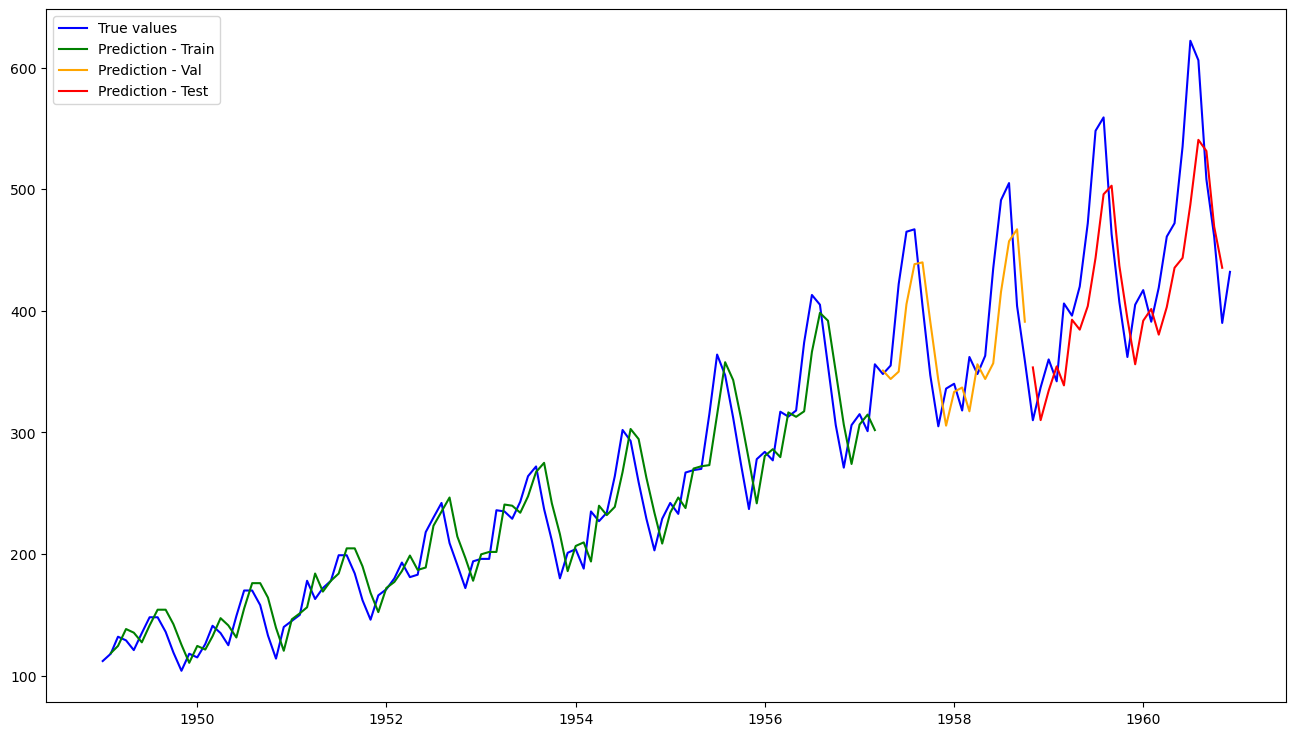

In [13]:
visualisation(model_gru_2,lback=lback)